In [261]:
import numpy as np
import pandas as pd
import math

In [262]:
def get_numpy_data_2(data_frame, features, output):
    selected_data_frame = data_frame[features]
    output_array = data_frame[output].to_numpy()
    np_selected_data_frame = selected_data_frame.to_numpy()
    total_row = np_selected_data_frame.shape[0]
    np_ones = np.ones(total_row).reshape(total_row, 1)
    
    features_array = np.append(np_ones, np_selected_data_frame, axis=1)
    
    return (features_array, output_array)

In [263]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

In [264]:
def predict_output(feature_matrix, weights):
    return np.dot(feature_matrix, weights)

In [265]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    error_derivative = 2.0 * np.dot(errors, feature)
    derivative = error_derivative
    
    if (not feature_is_constant):
        derivative += 2.0 * l2_penalty * weight
        
    return derivative

In [266]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

In [267]:
sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)

In [268]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price')

In [269]:
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights)
errors = test_predictions - example_output

In [270]:
print (feature_derivative_ridge(errors, example_features[:, 1], my_weights[1], 1, False))

-56554166815950.0


In [271]:
print (np.sum(errors * example_features[:, 1]) * 2 + 20)

-56554166815950.0


In [272]:
np.sum(errors)

-11223374665.0

In [273]:
print (feature_derivative_ridge(errors, example_features[:, 0], my_weights[0], 1, True))

-22446749330.0


In [274]:
example_features

array([[1.00e+00, 1.18e+03],
       [1.00e+00, 2.57e+03],
       [1.00e+00, 7.70e+02],
       ...,
       [1.00e+00, 1.02e+03],
       [1.00e+00, 1.60e+03],
       [1.00e+00, 1.02e+03]])

In [275]:
print (np.sum(errors) * 2)

-22446749330.0


In [276]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights,
                                      step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights)
    
    iter_count = 1
    while iter_count < max_iterations:
        predictions = predict_output(feature_matrix, weights)
        errors = predictions - output
        
        for i in range(len(weights)):
            feature_is_constant = i == 0
            derivative_i = feature_derivative_ridge(errors, 
                                                    feature_matrix[:, i],
                                                    weights[i],
                                                    l2_penalty,
                                                    feature_is_constant
                                                   )
            weights[i] -= step_size * derivative_i
        
        iter_count += 1
    
    # Not done yet
    return weights

In [277]:
train_data = pd.read_csv('wk3_kc_house_train_data.csv', dtype=dtype_dict)
test_data = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)

In [278]:
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features,
                                                           my_output
                                                          )

### FIrst, let's consider no regularization

In [279]:
step_size = 1e-12
max_iterations = 1000
initial_weights = [0.0, 0.0]

In [280]:
simple_weights_0_penalty = ridge_regression_gradient_descent(
    simple_feature_matrix,
    output,
    initial_weights,
    step_size,
    0.0,
    max_iterations
)

In [281]:
simple_weights_0_penalty

array([-8.53123842e-02,  2.64788506e+02])

In [282]:
print("%.1f" % simple_weights_0_penalty[1])

264.8


In [283]:
def calculate_rss(weights, feature, output):
    predicted_output = predict_output(feature, weights)
    errors = predicted_output - output
    return np.sum(errors * errors)

#### set L2 penalty to 1e11

In [284]:
simple_weights_high_penalty = ridge_regression_gradient_descent(
    simple_feature_matrix,
    output,
    initial_weights,
    step_size,
    1e11,
    max_iterations
)

In [285]:
simple_weights_high_penalty

array([ 6.96211225, 89.30826516])

In [286]:
print("%.1f" % simple_weights_high_penalty[1])

89.3


In [287]:
import matplotlib.pyplot as plt
%matplotlib inline

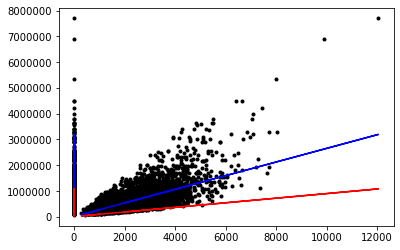

In [288]:
plt.plot(simple_feature_matrix, output,'k.',
         simple_feature_matrix, predict_output(simple_feature_matrix, simple_weights_0_penalty), 'b-',
         simple_feature_matrix, predict_output(simple_feature_matrix, simple_weights_high_penalty), 'r-'
        )

###  Rss on the test data for each of the set of weights above

In [289]:
rss_initial_penalty = calculate_rss(initial_weights, simple_test_feature_matrix, test_output)
print("Rss of initial weights: %s" % rss_initial_penalty)

Rss of initial weights: 927913649762512.0


In [290]:
rss_no_penalty = calculate_rss(simple_weights_0_penalty, simple_test_feature_matrix, test_output)
print("Rss no penalty: %f" % rss_no_penalty)

Rss no penalty: 143086951742082.062500


In [291]:
rss_high_penalty = calculate_rss(simple_weights_high_penalty, simple_test_feature_matrix, test_output)
print("Rss high penalty: %f" % rss_high_penalty)

Rss high penalty: 485877004589843.125000


### 2 features ['sqft_living', 'sqft_living15']

In [292]:
model_features = ['sqft_living', 'sqft_living15']

In [293]:
my_output = 'price'

In [294]:
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

In [295]:
initial_weights = [0.0, 0.0, 0.0]
step_size = 1e-12
max_iterations = 1000

In [296]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(
    feature_matrix,
    output,
    initial_weights,
    step_size,
    0.0,
    max_iterations
)

In [297]:
multiple_weights_0_penalty

array([-2.21914610e-01,  2.46515069e+02,  2.03931760e+01])

In [298]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(
    feature_matrix,
    output,
    initial_weights,
    step_size,
    1e11,
    max_iterations
)

In [299]:
multiple_weights_high_penalty

array([ 5.32175262, 70.80524389, 61.6387599 ])

In [300]:
print("%.1f" % multiple_weights_0_penalty[1])

246.5


In [301]:
print("%.1f" % multiple_weights_high_penalty[1])

70.8


###  Compute RSS on the Test data for three sets of weights

In [302]:
initial_rss_mul = calculate_rss(initial_weights, test_feature_matrix, test_output)

initial_rss_mul

927913649762512.0

In [303]:
no_penalty_rss_mul = calculate_rss(multiple_weights_0_penalty, test_feature_matrix, test_output)

no_penalty_rss_mul

142759080014996.2

In [304]:
high_penalty_rss_mul = calculate_rss(multiple_weights_high_penalty, test_feature_matrix,
                                     test_output
                                    )
high_penalty_rss_mul

356770522641569.9

### 25. Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.)


In [305]:
predict_with_0_penalty = predict_output(test_feature_matrix, multiple_weights_0_penalty)[0]
predict_with_0_penalty

514652.9483737952

In [306]:
predict_with_high_penalty = predict_output(test_feature_matrix, multiple_weights_high_penalty)[0]
predict_with_high_penalty

281143.86885502585

In [307]:
error_0_penalty = predict_with_0_penalty - test_output[0]
error_0_penalty

191652.9483737952

In [308]:
error_high_penalty = abs(predict_with_high_penalty - test_output[0])
error_high_penalty

41856.13114497415